# Optimization-based Control

In [1]:
import jax
import jax.numpy as jnp
import diffrax
import optax
import matplotlib.pyplot as plt

# Parameters
T_final = 50
N = 300           # number of control points
k_f = 0.2         # friction/damping coefficient
k_u = 1.0         # control gain
v_h = 0.5         # human walking speed (m/s)
d_target = 1.5    # target distance (m)

# Initial conditions
d_0 = 3.0         # initial distance (m)
v_r_0 = 0.0       # initial robot velocity (m/s)

t_grid = jnp.linspace(0, T_final, N + 1)

In [2]:
def ode(t, state, u_params):
    """ODE right-hand side: x = [d, v_r], u interpolated from u_params."""
    d, v_r = state
    u = jnp.interp(t, t_grid, u_params)
    dd_dt = v_h - v_r
    dv_r_dt = -k_f * v_r + k_u * u
    return jnp.array([dd_dt, dv_r_dt])

@jax.jit
def solve_and_cost(u_params):
    """Solve the ODE forward and compute the total cost."""
    # Clip controls to enforce bounds [-1, 1]
    u_clipped = jnp.clip(u_params, -1.0, 1.0)

    # Solve ODE using Diffrax
    sol = diffrax.diffeqsolve(
        diffrax.ODETerm(ode),
        diffrax.Tsit5(),
        t0=0, t1=T_final, dt0=T_final / N,
        y0=jnp.array([d_0, v_r_0]),
        args=u_clipped,
        saveat=diffrax.SaveAt(ts=t_grid),
        max_steps=10000,
    )
    d_sol = sol.ys[:, 0]

    # Running cost: integral of u^2 + (d - d_target)^2
    stage_costs = u_clipped**2 + (d_sol - d_target)**2
    running_cost = jnp.trapezoid(stage_costs, t_grid)

    # Terminal cost
    terminal_cost = (d_sol[-1] - d_target)**2

    return running_cost + terminal_cost

In [3]:
optimizer = optax.adam(learning_rate=0.01)

@jax.jit
def optimize(u_params, opt_state, n_steps=2000):
    """Run n_steps of Adam optimization using jax.lax.scan."""
    def step(carry, _):
        u, opt_state = carry
        cost, grads = jax.value_and_grad(solve_and_cost)(u)
        updates, opt_state = optimizer.update(grads, opt_state, u)
        u = optax.apply_updates(u, updates)
        u = jnp.clip(u, -1.0, 1.0)  # enforce bounds
        return (u, opt_state), cost

    (u_opt, opt_state), costs = jax.lax.scan(
        step, (u_params, opt_state), None, length=n_steps
    )
    return u_opt, costs

# Run optimization
u_params = jnp.zeros(N + 1)
opt_state = optimizer.init(u_params)
u_opt, costs = optimize(u_params, opt_state)
print(f"Final cost: {costs[-1]:.4f}")

# Extract solution by solving the ODE one final time
sol = diffrax.diffeqsolve(
    diffrax.ODETerm(ode),
    diffrax.Tsit5(),
    t0=0, t1=T_final, dt0=T_final / N,
    y0=jnp.array([d_0, v_r_0]),
    args=u_opt,
    saveat=diffrax.SaveAt(ts=t_grid),
    max_steps=10000,
)
d_sol = sol.ys[:, 0]
v_r_sol = sol.ys[:, 1]
u_sol = u_opt

Final cost: 7.5177


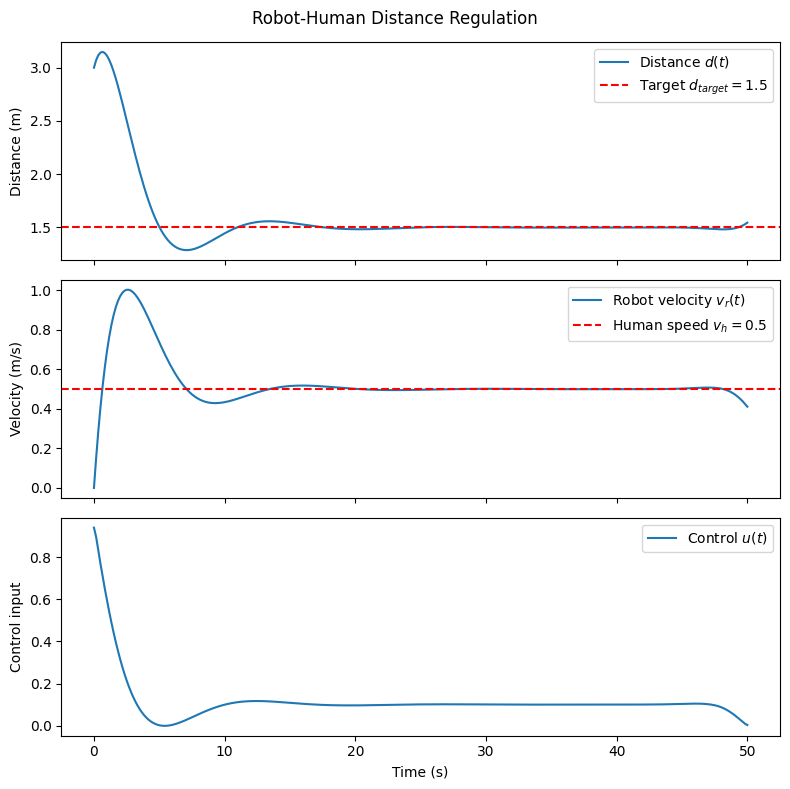

In [4]:
fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

axes[0].plot(t_grid, d_sol, label="Distance $d(t)$")
axes[0].axhline(d_target, color="r", linestyle="--", label=f"Target $d_{{target}}={d_target}$")
axes[0].set_ylabel("Distance (m)")
axes[0].legend()

axes[1].plot(t_grid, v_r_sol, label="Robot velocity $v_r(t)$")
axes[1].axhline(v_h, color="r", linestyle="--", label=f"Human speed $v_h={v_h}$")
axes[1].set_ylabel("Velocity (m/s)")
axes[1].legend()

axes[2].plot(t_grid, u_sol, label="Control $u(t)$")
axes[2].set_ylabel("Control input")
axes[2].set_xlabel("Time (s)")
axes[2].legend()

plt.suptitle("Robot-Human Distance Regulation")
plt.tight_layout()
plt.show()